In [1]:
# basic loading
%matplotlib inline
import numpy as np
from math import *
import matplotlib.pyplot as pyplt
import emcee


# Data: 6 heads among 10 tosses.

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:16: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:24: RuntimeWarning: divide by zero encountered in log


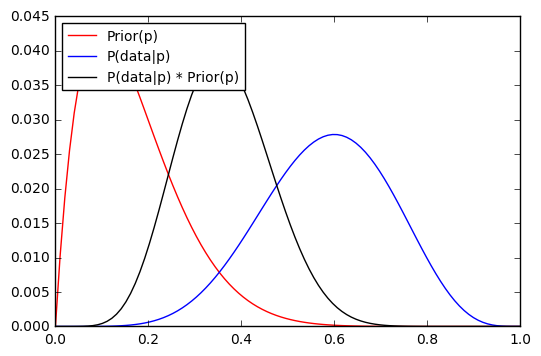

In [2]:
# define a prior
def prior(p):
    # vectorize
    p = np.array(p, ndmin = 1)
    # calculate return_me
    return_me = p**1 * (1 - p)**9
    # sanitize
    return_me[ (p <= 0.0) ] = 0.0
    return_me[ (p >= 1.0) ] = 0.0
    return return_me

# define a log likelihood
def lnprob(p):
    # P(data | p) = C^10_6 * p**6 * (1-p)**4
    prob = p**6 * (1-p)**4
    lnprob = np.log(prob)
    return lnprob

# define a ln(total_p)
def lntotp(p):
    # total_p = prob * prior
    # lntotal_p = lnprob + lnprior
    # some tuning
    return lnprob(p) + np.log(prior(p))

# evaluate
plot_p              = np.linspace(0.0,1.0,100)
plot_prior          = prior(plot_p)
plot_prob           = np.exp(lnprob(plot_p))
plot_prob_and_prior = np.exp(lntotp(plot_p))

# plot
pyplt.plot(plot_p, plot_prior / np.sum(plot_prior)                  , color = "red"  , label = "Prior(p)")
pyplt.plot(plot_p, plot_prob / np.sum(plot_prob)                    , color = "blue" , label = "P(data|p)")
pyplt.plot(plot_p, plot_prob_and_prior / np.sum(plot_prob_and_prior), color = "black", label = "P(data|p) * Prior(p)")
pyplt.legend(loc = 2, numpoints = 1, prop = {'size':10})

In [3]:
# lets emc this.

# dimension
ndim = 1 # which is the probability p
# walkers
nwalkers = 100
# nstep
nstep = 1000
# initial positions - in the shape of (nwalkers, ndim)
np.random.seed(190)
initial_positions = np.random.uniform(0.1,0.15, size = ndim * nwalkers)
initial_positions = initial_positions.reshape((nwalkers, ndim))

# create emcee sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, lntotp)
# run it!
_ = sampler.run_mcmc(initial_positions, nstep)
# extract the chain
chain = sampler.chain

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:24: RuntimeWarning: divide by zero encountered in log


shape of chain: (100, 1000, 1)


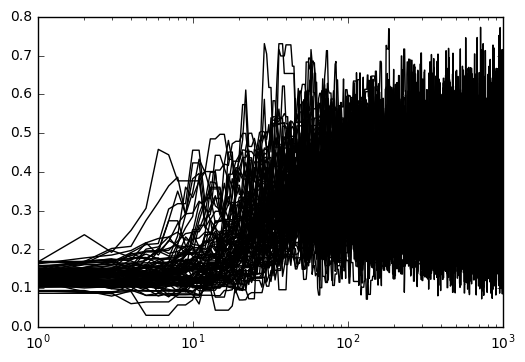

In [4]:
# what is the chain?
print "shape of chain:", chain.shape 
# look at timeline - Yes, I am using for loop now.
for nw in range(nwalkers):
    pyplt.plot(np.arange(nstep) + 1, chain[nw,:,0], color = "k")
pyplt.xscale("log")


In [5]:
# burn_in
nburnin                    =   200
chain_cleaned              =   chain[:,nburnin:,:].reshape((-1,ndim))
print "shape of chain_cleaned:", chain_cleaned.shape


shape of chain_cleaned: (80000, 1)


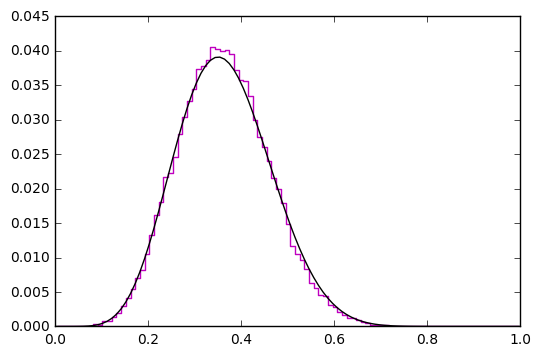

In [6]:
# likeilhood (i.e., histogram)
hist       =   np.histogram(chain_cleaned[:,0], bins = plot_p, density = True)[0]
# plot
pyplt.step(0.5*(plot_p[1:] + plot_p[:-1]), hist / np.sum(hist), color = "m", label = "emcee", where = "mid")
pyplt.plot(plot_p                        , plot_prob_and_prior / np.sum(plot_prob_and_prior), color = "black", label = "P(data|p) * Prior(p)")
